In [1]:
from langchain_teddynote import logging
from dotenv import load_dotenv

load_dotenv()

logging.langsmith("LangGraph-Modules")



LangSmith 추적을 시작합니다.
[프로젝트명]
LangGraph-Modules


In [4]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_teddynote.graphs import visualize_graph
from langchain_teddynote.tools import GoogleNews


########## 1. 상태 정의 ##########
# 상태 정의
class State(TypedDict):
    # 메시지 목록 주석 추가
    messages: Annotated[list, add_messages]


########## 2. 도구 정의 및 바인딩 ##########
# 도구 초기화
# 키워드로 뉴스 검색하는 도구 생성
news_tool = GoogleNews()


@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)


tools = [search_keyword]

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini")

# 도구와 LLM 결합
llm_with_tools = llm.bind_tools(tools)


########## 3. 노드 추가 ##########
# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# 상태 그래프 생성
graph_builder = StateGraph(State)

# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)


# 도구 노드 생성 및 추가
tool_node = ToolNode(tools=tools)

# 도구 노드 추가
graph_builder.add_node("tools", tool_node)

# 조건부 엣지
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

########## 4. 엣지 추가 ##########

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# chatbot > END
graph_builder.add_edge("chatbot", END)

########## 5. MemorySaver 추가 ##########

# 메모리 저장소 초기화
memory = MemorySaver()

그래프 컴파일 후 , tools 노드 전에 interrupt_before 지정.

In [6]:
graph = graph_builder.compile(checkpointer=memory)

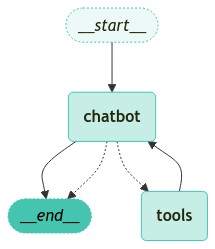

In [7]:
visualize_graph(graph)

In [11]:
from langchain_teddynote.messages import pretty_print_messages
from langchain_core.runnables import RunnableConfig

# 질문
question = "AI 관련 최신 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    stream_mode="values",
    interrupt_before=["tools"],  # tools 실행 전 interrupt(tools 노드 실행 전 중단)
):
    for key, value in event.items():
        # key 는 노드 이름
        print(f"\n[{key}]\n")

        # value 는 노드의 출력값
        # print(value)
        pretty_print_messages(value)

        # value 에는 state 가 dict 형태로 저장(values 의 key 값)
        if "messages" in value:
            print(f"메시지 개수: {len(value['messages'])}")


[messages]

================================ Human Message =================================

AI 관련 최신 뉴스를 알려주세요.

[messages]

================================ Human Message =================================

AI 관련 최신 뉴스를 알려주세요.
================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_cszJr2ABNCMVzymSq05LPu89)
 Call ID: call_cszJr2ABNCMVzymSq05LPu89
  Args:
    query: AI


In [12]:
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)

# 다음 스냅샷 상태
snapshot.next

('tools',)

__END__에 도달하지 않았기 때문에 .next의 값이 'tools'를 가지고 있다.

In [13]:
from langchain_teddynote.messages import display_message_tree

# 메시지 스냅샷에서 마지막 메시지 추출
existing_messages = snapshot.values["messages"][-1]

display_message_tree(existing_messages.tool_calls)

    index [0]
        name: "search_keyword"
        args: {"query": "AI"}
        id: "call_cszJr2ABNCMVzymSq05LPu89"
        type: "tool_call"


이전에 종료된 지점 이후부터 다시 실행.

In [14]:
events = graph.stream(None, config, stream_mode = "values")

for event in events:
    # 메시지가 이벤트에 포함된 경우
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_cszJr2ABNCMVzymSq05LPu89)
 Call ID: call_cszJr2ABNCMVzymSq05LPu89
  Args:
    query: AI
================================= Tool Message =================================
Name: search_keyword

[{"url": "https://news.google.com/rss/articles/CBMiVkFVX3lxTE9CemxrWGpGVnJybWtBYU1ycHpINENocEUtUVE5TGx5U1pEdXRvU0c5Z0wzSGhLbHVNQjlrXzMtZkp2LWhMNEQ3Sk01bmsyaUZZTm5zTExB?oc=5", "content": "\"엔비디아 AI칩 블랙웰, 서버 탑재시 과열\" - ZD넷 코리아"}, {"url": "https://news.google.com/rss/articles/CBMiW0FVX3lxTE9TTG9id0N2ekRlZHdpbHhkUFNkdnRYak9kUThETW9SSFV1ZmUtZzNpamZRNEttWTlfOFBNMmFxdVFuYko4ZmxHYnVIVmxaQU95MDFzTFo5UDlzVkHSAV5BVV95cUxNdHZBU3ZEMFRocXVZMFVyZ2ZEVDh1MkNOdEtXTGZuYUVfWkg5Q0dvRjRHd1QtM2JZNnRTNlIzSmdpN2FMbDFIZWJIZVZiM0JJZ2xOS3FlMllLTzZLSWZn?oc=5", "content": "\"엔비디아 AI칩 '블랙웰' 서버 과열 문제…해결 시도중\"(종합) - 연합뉴스"}, {"url": "https://news.google.com/rss/articles/CBMiYEFVX3lxTE5GZVJkdDh3WlU5SGthMDcyeDZqaE1CSTZp

interrupt를 통해 챗봇에 인간이 개입할 수 있는 실행을 추가하여 인간의 감독과 개입이 가능.<br>
서비스에 적용할 경우 잠재적인 UI 제공이 가능하고, checkpointer를 통해 그래프가 무기한 중지되고 언제든 재개 가능.


상태 기록을 통해 원하는 상태를 지정하여 해당지점에서 다시 시작 가능.

In [19]:
to_replay = None

# 상태 기록 가져오기
for state in graph.get_state_history(config):
    # 메시지 수 및 다음 상태 출력
    print("메시지 수: ", len(state.values["messages"]), "다음 노드: ", state.next)
    print("-" * 80)
    # 특정 상태 선택 기준: 채팅 메시지 수
    if len(state.values["messages"]) == 3:
        to_replay = state

메시지 수:  4 다음 노드:  ()
--------------------------------------------------------------------------------
메시지 수:  3 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
메시지 수:  2 다음 노드:  ('tools',)
--------------------------------------------------------------------------------
메시지 수:  1 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
메시지 수:  0 다음 노드:  ('__start__',)
--------------------------------------------------------------------------------


In [20]:
print(to_replay.next)

print(to_replay.config)

('chatbot',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efa5c45-b79e-6ef4-8002-5b21cf0d15c0'}}


- **replay 기능**<br>

검색이 끝나고 결과가 chatbot 노드에 전달하면서 최종 답변을 생성하는 과정을 다시 실행.

In [21]:
# `to_replay.config`는 `checkpoint_id`는 체크포인터에 저장된 상태에 해당
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    # 메시지가 이벤트에 포함된 경우
    if "messages" in event:
        # 마지막 메시지 출력
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: search_keyword

[{"url": "https://news.google.com/rss/articles/CBMiVkFVX3lxTE9CemxrWGpGVnJybWtBYU1ycHpINENocEUtUVE5TGx5U1pEdXRvU0c5Z0wzSGhLbHVNQjlrXzMtZkp2LWhMNEQ3Sk01bmsyaUZZTm5zTExB?oc=5", "content": "\"엔비디아 AI칩 블랙웰, 서버 탑재시 과열\" - ZD넷 코리아"}, {"url": "https://news.google.com/rss/articles/CBMiW0FVX3lxTE9TTG9id0N2ekRlZHdpbHhkUFNkdnRYak9kUThETW9SSFV1ZmUtZzNpamZRNEttWTlfOFBNMmFxdVFuYko4ZmxHYnVIVmxaQU95MDFzTFo5UDlzVkHSAV5BVV95cUxNdHZBU3ZEMFRocXVZMFVyZ2ZEVDh1MkNOdEtXTGZuYUVfWkg5Q0dvRjRHd1QtM2JZNnRTNlIzSmdpN2FMbDFIZWJIZVZiM0JJZ2xOS3FlMllLTzZLSWZn?oc=5", "content": "\"엔비디아 AI칩 '블랙웰' 서버 과열 문제…해결 시도중\"(종합) - 연합뉴스"}, {"url": "https://news.google.com/rss/articles/CBMiYEFVX3lxTE5GZVJkdDh3WlU5SGthMDcyeDZqaE1CSTZpX2xNS3BFaHFaejVtMldDYi1RVWVjZHhMa0ZzVWRfUXE2c090dkRHWXZIUmZCd0VnWG5PeEJPNGhuYW5rZzZxdw?oc=5", "content": "‘더 많이 학습’ AI 확장 모델 한계왔나…엔비디아 수익감소 우려도 - 한겨레"}, {"url": "https://news.google.com/rss/articles/CBMia